# Software MCA

### StemLab 10 bit board (DAQ) configuration:
- Both input channels are configured with the jumper in LV position (high sensitivity, $\pm$ 1 V)
- Visit Red Pitaya IP (dashboard) > Development > Python Programming

-----------------------------

Additional Multi-Channel Analyzer implemented in software, for specific ionization measurements. Please note that the original setup with organic plastic scintillator is very limited for this purposes because of the reduced linearity of these detectors. This functionality is more useful with radioactive sources (gamma) since the cosmic muons are mainly between MIPs (Minimum Ionization Particles) and the following slow rising and plateau because of their high energy. 

- It can be still interesting to perform some signal spectroscopy with a Multi-Channel analyzer for some reasons, for example, for characterizing the energy distribution of the 
background noise due to natural environmental radioactivity 

-----------------------------

 <p align="left" width="70">
  <img src="https://meroli.web.cern.ch/img/lecture/straggling/Lectur1.gif" width="550">

In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

### Initial configuration

In [ ]:
# Import the FPGA firmware Overlay
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()

# Import LEDs
LED = FPGA.led
aq_started = LED(1, 0)
trig_armed = LED(2, 0)
event      = LED(3, 0)

# Import GPIOs for external event counter / slow trigger
GPIO = FPGA.gpio
gpio_o = GPIO('p', 0, "out")

# Define the FPGA oscilloscope objects
osc = [fpga.osc(ch, 1.0) for ch in range(2)]

# Set data rate decimation
for ch in osc:
    # data rate decimation = 1, keep 125 MHz sampling frequency
    ch.decimation = 1

    # trigger timing [sample periods]
    N = ch.buffer_size
    ch.trigger_pre  = 0
    ch.trigger_post = N
    
    # osc[0] is controlling both channels
    ch.sync_src = fpga.sync_src["osc0"]

# Setup trigger on scintillator signals
osc[0].level = [0.23, 0.2]
osc[0].edge  = 'pos'
osc[1].level = [0.23, 0.2]
osc[1].edge  = 'pos'

for ch in osc:
    ch.trig_src = fpga.trig_src["osc1"]

### Software Multi-Channel-Analyzer with digital signal integration

In [32]:
class MCA:
    def __init__(self, num_bins=2048, bin_width=1):
        self.num_bins = num_bins
        self.bin_width = bin_width
        self.bins = np.zeros(num_bins)
        self.baseline = None
    
    def remove_baseline(self, waveform):
        # Determine baseline using a rolling mean of the first 10% of the waveform
        baseline_window = int(len(waveform) * 0.1)
        self.baseline = np.mean(waveform[:baseline_window])
        
        # Subtract baseline from the entire waveform
        baseline_removed = waveform - self.baseline
        
        return baseline_removed
    
    def integrate(self, waveform):
        # Integrate the waveform by summing up the areas of the trapezoids formed by adjacent samples
        x = np.arange(len(waveform)) * self.bin_width
        trapezoid_areas = (waveform[1:] + waveform[:-1]) / 2 * self.bin_width
        integral = np.sum(trapezoid_areas)
        
        return integral
    
    def fill_mca(self, waveform):
        # Remove baseline and integrate the waveform
        baseline_removed = self.remove_baseline(waveform)
        integral = self.integrate(baseline_removed)

        # Determine which bin to fill based on the integral
        bin_num = int(integral / (self.num_bins * self.bin_width))
        if bin_num >= 0 and bin_num < self.num_bins:
            self.bins[bin_num] += 1

    
    def plot_spectrum(self):
        # Plot the MCA spectrum
        x = np.arange(self.num_bins) * self.bin_width
        plt.plot(x, self.bins, color="red")
        plt.xlabel('Ionization channels')
        plt.ylabel('Counts')
        plt.grid()
        plt.show()

    def reset(self):
        # Reset all bin counts to zero
        self.bins = np.zeros(self.num_bins)


### MCA Class testbench

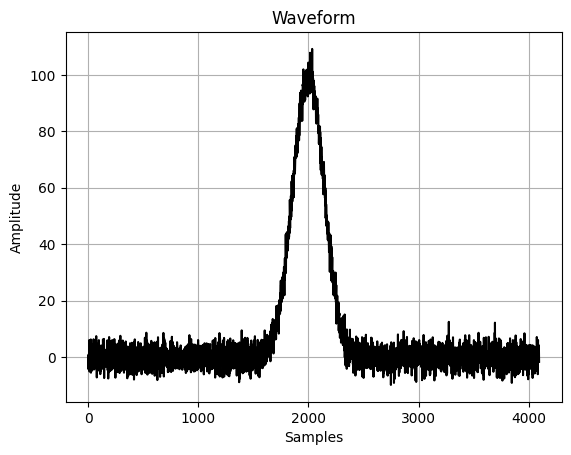

In [38]:
# Create an MCA object
mca = MCA()

# Generate some fake data
def getWaveform():
    x = np.arange(0, 4096)
    waveform = np.exp(-((x-2000)/200)**2) * 100 + np.random.normal(size=4096, scale=3)
    return waveform

waveform = getWaveform()
plt.plot(waveform, color="black")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid()


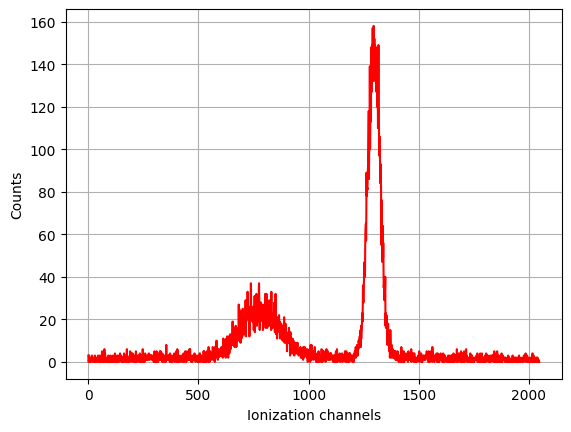

In [41]:
mca.reset()

# Fill the MCA with some waveforms
for i in range(5000):
    A = np.random.normal(loc=45, scale=5)
    B = np.random.normal(loc=55, scale=50)
    mca.fill_mca(getWaveform() * A)
    mca.fill_mca(getWaveform() * B)

for i in range(10000):
    C = np.random.normal(loc=75, scale=1)
    mca.fill_mca(getWaveform() * C)

# Plot the MCA spectrum
mca.plot_spectrum()

### Data acquisition RUN

In [ ]:
aq_started.write(1)

MAX_EVEN_NUM = 1e10
MAX_RAM_BUFF = 100
counter = 0
data_buf = []

while(counter < MAX_EVENT_NUM):
    counter = counter + 1
    # reset and start
    osc[0].reset()
    osc[0].start()
    # wait for trigger
    trig_armed.write(1)
    # Reset the slow GPIO output for external event counting
    gpio_o.write(False)
    while (osc[0].status_run()): pass
    # "fast" (code execution time) pulse on the slow GPIO output for slow trigger and external event counting with scaler
    gpio_o.write(True)
    trig_armed.write(0)
    timestamp = time.time()
    print('Recorded event at ',  , " timestamp = " ,str(timestamp))
    data0 = osc[0].data(N)
    data1 = osc[1].data(N)
    #Single event formatting as a dictionary
    event = {'event_label'  : 'SCINTILLATOR_EVENT',
             'timestamp'    :  str(timestamp),
             'data0'        :  data0,
             'data1'        :  data1
            }
    # Append the current event to the data buffer
    data_buf.append(event)

    # Toggle event LED
    if (counter % 2 == 0):
        event.write(0)
    else:
        event.write(1)

    # Write events to disk (pickle binary format) then cleanup the RAM buffer
    if (counter > MAX_RAM_BUFF):
        fname = 'Run_' + str(time.time())
        with open('{}.p'.format(fname), 'wb') as handle:
            pickle.dump(data_buf, handle, protocol=pickle.HIGHEST_PROTOCOL)
        data_buf.clear()

# Run closed
aq_started.write(0)

### Spectroscopy viewer